In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
#import torch.utils.checkpoint as cp
import csv
from sklearn import metrics
import math
import random
%matplotlib inline

train_num = 465
train_num1 = 372
train_num2 = 93
test_num = 117
batch_size = 8
epoch_num = 50
mask_weight = 0.1
alpha = 0.7
displacement = True
#is_training = False

#cnt=0

In [2]:
class m3dvDataset(data.Dataset):
    def __init__(self,data_dir,label_dir,train,displacement=False,vox_transform=transforms.ToTensor(),seg_transform=transforms.ToTensor()):
        self.data_dir=data_dir
        self.train=train
        self.displacement=displacement
        tmp=np.loadtxt(label_dir,dtype=str,delimiter=",",skiprows=1)
        self.label={}
        for i in range(tmp.shape[0]):
            self.label[tmp[i,0]+'.npz']=int(tmp[i,1])
        self.vox_transform=vox_transform
        self.seg_transform=seg_transform
        self.npz=os.listdir(data_dir)
        self.npz.sort()
    def __getitem__(self,index):
        #global cnt
        if self.train:
            if self.displacement:
                dx=np.random.randint(9)-4
                dy=np.random.randint(9)-4
                dz=np.random.randint(9)-4
                #cnt+=1
                voxel=np.load(self.data_dir+self.npz[index])['voxel'][34+dx:66+dx,34+dy:66+dy,34+dz:66+dz]
                seg=np.load(self.data_dir+self.npz[index])['seg'][34+dx:66+dx,34+dy:66+dy,34+dz:66+dz]
            else:
                voxel=np.load(self.data_dir+self.npz[index])['voxel'][34:66,34:66,34:66]
                seg=np.load(self.data_dir+self.npz[index])['seg'][34:66,34:66,34:66]
            voxel=self.vox_transform(voxel)
            voxel=torch.unsqueeze(voxel, 0)
            seg=self.seg_transform(seg)
            seg=seg.long()
            label=self.label[self.npz[index]]
            return voxel,seg,label
        else:
            index=index+372
            voxel=np.load(self.data_dir+self.npz[index])['voxel'][34:66,34:66,34:66]
            voxel=self.vox_transform(voxel)
            voxel=torch.unsqueeze(voxel, 0)
            seg=np.load(self.data_dir+self.npz[index])['seg'][34:66,34:66,34:66]
            seg=self.seg_transform(seg)
            seg=seg.long()
            label=self.label[self.npz[index]]
            return voxel,seg,label
    def __len__(self):
        if self.train==1:
            return 372
        elif self.train==0:
            return 93
        else:
            return 465
    

In [3]:
def get_mean_and_std():
    dataset=m3dvDataset('../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/','../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv',train=1)
    #dataset=m3dvDataset('sjtu-ee228-2020/train_val/train_val/','sjtu-ee228-2020/train_val.csv')
    trains = [d[0].data.numpy() for d in dataset]
    return np.mean(trains),np.std(trains)

mean,std=get_mean_and_std()
print(mean,std)

0.29079765 0.26018268


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vox_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))
])

seg_transform=transforms.Compose([
    transforms.ToTensor(),
])

train_dataset=m3dvDataset('../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/','../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv',train=1,displacement=displacement,vox_transform=vox_transform,seg_transform=seg_transform)
#train_dataset=m3dvDataset('sjtu-ee228-2020/train_val/train_val/','sjtu-ee228-2020/train_val.csv',vox_transform=vox_transform,seg_transform=seg_transform)
train_dataset2=m3dvDataset('../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/','../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv',train=1,displacement=False,vox_transform=vox_transform,seg_transform=seg_transform)
test_dataset=m3dvDataset('../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/','../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv',train=0,displacement=False,vox_transform=vox_transform,seg_transform=seg_transform)
full_dataset=m3dvDataset('../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/','../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv',train=2,displacement=displacement,vox_transform=vox_transform,seg_transform=seg_transform)


train_loader=data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=False)
train_loader2=data.DataLoader(train_dataset2,batch_size=1,shuffle=False,drop_last=False)
test_loader=data.DataLoader(test_dataset,batch_size=1,shuffle=False,drop_last=False)
full_loader=data.DataLoader(full_dataset,batch_size=batch_size,shuffle=True,drop_last=False)

In [5]:
class _denselayer(nn.Module):
    def __init__(self,channel_size,bn_size=4,growth_rate=16):
        super(_denselayer,self).__init__()
        self.BN1=nn.BatchNorm3d(channel_size)
        self.ReLU1=nn.ReLU(inplace=True)
        self.Conv1=nn.Conv3d(channel_size,bn_size*growth_rate,kernel_size=1,stride=1,padding=0,bias=True)
        self.BN2=nn.BatchNorm3d(bn_size*growth_rate)
        self.ReLU2=nn.ReLU(inplace=True)
        self.Conv2=nn.Conv3d(bn_size*growth_rate,growth_rate,kernel_size=3,stride=1,padding=1,bias=True)
        
    def forward(self,x):
        x=torch.cat(x, 1)
        x=self.BN1(x)
        x=self.ReLU1(x)
        x=self.Conv1(x)
        x=self.BN2(x)
        x=self.ReLU2(x)
        x=self.Conv2(x)
        return x

class _denseblock(nn.ModuleDict):
    def __init__(self,num_layers,num_input_features,bn_size=4,growth_rate=16):
        super(_denseblock,self).__init__()
        for i in range(num_layers):
            layer=_denselayer(num_input_features+i*growth_rate,bn_size,growth_rate)
            self.add_module("denselayer%d" % (i+1,),layer)
            
    def forward(self,x):
        features = [x]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)
    
def dice_loss(inputs, target):
    smooth = 1.0

    iflat = inputs.reshape(-1)
    tflat = target.reshape(-1)
    intersection = (iflat * tflat).sum()
    loss=1 - ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))
    return loss

def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)

def mixup_data(x, segs, labels, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    segs_a, segs_b = segs, segs[index]
    labels_a, labels_b = labels, labels[index]
    return mixed_x, segs_a, segs_b, labels_a, labels_b, lam

In [7]:
class Net2(nn.Module):
    def __init__(self,growth_rate=16,num_layers=4,num_init_features=16,bn_size=4,num_classes=2):
        super(Net2, self).__init__()
        self.pre=nn.Sequential(
            nn.Conv3d(1, num_init_features, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm3d(num_init_features),
            #nn.ReLU(inplace=True),
        )
        self.db1=_denseblock(
                num_layers=num_layers,
                num_input_features=num_init_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )        
        num_features=num_init_features+num_layers*growth_rate        
        mask_features1=num_features
        self.tr1=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )       
        num_features = num_features//2  
        self.db2=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        mask_features2=num_features
        self.tr2=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )     
        num_features = num_features//2 
        self.db3=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        mask_features3=num_features
        self.tr3=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )       
        num_features = num_features//2  
        self.db4=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        self.final = nn.Sequential(nn.Conv3d(num_features,num_features//2,kernel_size=3,stride=1,padding=1,bias=True),
                                  )
        num_features = num_features//2 
        self.fc=nn.Sequential(nn.Linear(num_features,num_features),
                              nn.ReLU(inplace=True),
                              nn.Dropout(),
                              nn.Linear(num_features,num_features),
                              nn.ReLU(inplace=True),
                              nn.Dropout(),
                             nn.Linear(num_features,num_classes))
        #self.fc=nn.Sequential(
         #                     nn.Linear(num_features,num_classes),
          #                   )
        self.maskconv1=nn.ConvTranspose3d(mask_features3,mask_features2,kernel_size=2,stride=2)
        self.maskconv2=nn.ConvTranspose3d(mask_features2,mask_features1,kernel_size=2,stride=2)
        self.maskconv3=nn.Conv3d(mask_features1,1,kernel_size=1,stride=1)
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)
        
    def forward(self,x):
        y1=self.pre(x)
        #print(x.shape)
        y1=self.db1(y1)
        #print(y1.shape)
        y2=self.db2(self.tr1(y1))
        #print(y2.shape)
        y3=self.db3(self.tr2(y2))
        #print(y3.shape)
        out=self.db4(self.tr3(y3))
        #print(out.shape)
        out=self.final(out)
        out=F.adaptive_avg_pool3d(out, (1, 1, 1))
        out=torch.flatten(out, 1)
        out=self.fc(out)
        #out=F.softmax(out,dim=1)
        mask=torch.sigmoid(self.maskconv3(self.maskconv2(self.maskconv1(y3)+y2)+y1))
        return mask,out

In [23]:
class Net4(nn.Module):
    def __init__(self,growth_rate=16,num_layers=4,num_init_features=8,bn_size=4,num_classes=2):
        super(Net4, self).__init__()
        self.pre=nn.Sequential(
            nn.Conv3d(1, num_init_features, kernel_size=3,stride=1,padding=1),
            #nn.BatchNorm3d(num_init_features),
            #nn.ReLU(inplace=True),
        )
        self.pre2=nn.Conv3d(1, num_init_features, kernel_size=5,stride=1,padding=2)
        self.pre3=nn.Conv3d(1, num_init_features, kernel_size=7,stride=1,padding=3)
        num_init_features=num_init_features*3
        '''
        self.pre4=nn.Conv3d(num_init_features,num_init_features,kernel_size=3,stride=1,padding=1)
        '''
        self.db1=_denseblock(
                num_layers=num_layers,
                num_input_features=num_init_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )        
        num_features=num_init_features+num_layers*growth_rate        
        mask_features1=num_features
        self.tr1=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )       
        num_features = num_features//2  
        self.db2=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        mask_features2=num_features
        self.tr2=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )     
        num_features = num_features//2 
        self.db3=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        mask_features3=num_features
        self.tr3=nn.Sequential(nn.Conv3d(num_features,num_features // 2,kernel_size=3,padding=1,bias=True),
                              nn.AvgPool3d(2, stride=2)
                              )       
        num_features = num_features//2  
        self.db4=_denseblock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
            )   
        num_features=num_features+num_layers*growth_rate  
        mask_features4=num_features
        #print(num_features)
        self.final1 = nn.Conv3d(num_features,num_features//6,kernel_size=3,stride=1,padding=1,bias=True)
        self.final2 = nn.Conv3d(num_features,num_features//6,kernel_size=5,stride=1,padding=2,bias=True)
        self.final3 = nn.Conv3d(num_features,num_features//6,kernel_size=7,stride=1,padding=3,bias=True)
        
        num_features = (num_features//6)*3 
        self.fc=nn.Sequential(
            nn.Linear(num_features,num_features),
                              nn.ReLU(inplace=True),
                              nn.Dropout(),
                              nn.Linear(num_features,num_features),
                              nn.ReLU(inplace=True),
                              nn.Dropout(),
                             nn.Linear(num_features,num_classes))
        #self.fc=nn.Sequential(
         #                     nn.Linear(num_features,num_classes),
          #                   )
        
        self.maskconv1=nn.ConvTranspose3d(mask_features4,mask_features3,kernel_size=2,stride=2)
        self.maskconv2=nn.ConvTranspose3d(mask_features3,mask_features2,kernel_size=2,stride=2)
        self.maskconv3=nn.ConvTranspose3d(mask_features2,mask_features1,kernel_size=2,stride=2)
        self.maskconv4=nn.Conv3d(mask_features1,1,kernel_size=1,stride=1)
        for name, param in self.named_parameters():
            if 'conv' in name and 'weight' in name:
                n = param.size(0) * param.size(2) * param.size(3)
                param.data.normal_().mul_(math.sqrt(2. / n))
            elif 'norm' in name and 'weight' in name:
                param.data.fill_(1)
            elif 'norm' in name and 'bias' in name:
                param.data.fill_(0)
            elif 'classifier' in name and 'bias' in name:
                param.data.fill_(0)
        
    def forward(self,x):
        #print(x.shape)
        y1=torch.cat((self.pre(x),self.pre2(x),self.pre3(x)),1)
        #y1=self.pre4(y1)
        #print(y1.shape)
        y1=self.db1(y1)
        #print(y1.shape)
        y2=self.db2(self.tr1(y1))
        #print(y2.shape)
        y3=self.db3(self.tr2(y2))
        #print(y3.shape)
        y4=self.db4(self.tr3(y3))
        #print(out.shape)
        out=torch.cat((self.final1(y4),self.final2(y4),self.final3(y4)),1)
        out=F.adaptive_avg_pool3d(out, (1, 1, 1))
        out=torch.flatten(out, 1)
        out=self.fc(out)
        #out=F.softmax(out,dim=1)
        mask=torch.sigmoid(self.maskconv4(self.maskconv3(self.maskconv2(self.maskconv1(y4)+y3)+y2)+y1))
        return mask,out

In [24]:
net1=Net4(growth_rate=16,num_layers=4,num_init_features=5,bn_size=4).to(device)

optimizer = torch.optim.Adam(net1.parameters(),lr=4e-5,weight_decay=1e-3)
#criterion = nn.CrossEntropyLoss()
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.5)

In [25]:
trainloss_epoch=[]
trainacc_epoch=[]
trainAUC_epoch=[]
testloss_epoch=[]
testacc_epoch=[]
testAUC_epoch=[]
do_transpose=True
do_flip=True
do_mixup=True
max_auc=0.6
min_loss=10

Epoch:  0 | trainloss: 0.7726
Epoch:  0 | trainaccuracy: 54.03%
Epoch:  0 | trainAUC: 0.5223
Epoch:  0 | testloss: 0.7819
Epoch:  0 | testaccuracy: 52.69%
Epoch:  0 | testAUC: 0.5033
Current minimum loss, epoch: 0
Epoch:  1 | trainloss: 0.7405
Epoch:  1 | trainaccuracy: 60.75%
Epoch:  1 | trainAUC: 0.6405
Epoch:  1 | testloss: 0.7414
Epoch:  1 | testaccuracy: 59.14%
Epoch:  1 | testAUC: 0.6186
Current maximum AUC, epoch: 1
Current minimum loss, epoch: 1
Epoch:  2 | trainloss: 0.7464
Epoch:  2 | trainaccuracy: 61.83%
Epoch:  2 | trainAUC: 0.6631
Epoch:  2 | testloss: 0.7519
Epoch:  2 | testaccuracy: 54.84%
Epoch:  2 | testAUC: 0.5949
Epoch:  3 | trainloss: 0.7252
Epoch:  3 | trainaccuracy: 62.10%
Epoch:  3 | trainAUC: 0.6756
Epoch:  3 | testloss: 0.7333
Epoch:  3 | testaccuracy: 51.61%
Epoch:  3 | testAUC: 0.6316
Current maximum AUC, epoch: 3
Current minimum loss, epoch: 3
Epoch:  4 | trainloss: 0.7241
Epoch:  4 | trainaccuracy: 58.06%
Epoch:  4 | trainAUC: 0.6608
Epoch:  4 | testloss: 

Text(0, 0.5, 'AUC')

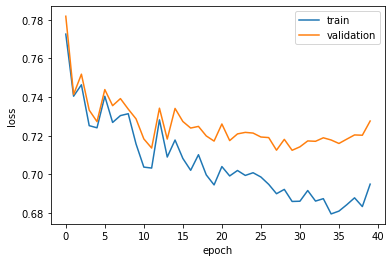

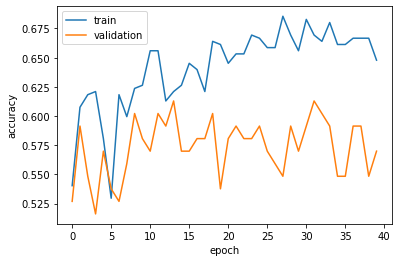

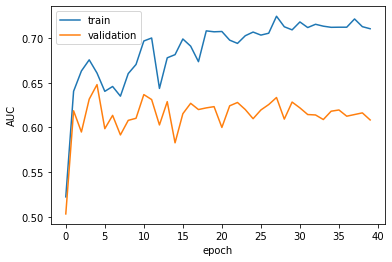

In [27]:
epoch_num=40
for epoch in range(epoch_num):
    net1.train()
    #is_training = True
    for step,(voxels,segs,labels) in enumerate(train_loader):
        if do_mixup:
            voxels, segs_a, segs_b, labels_a, labels_b, lam = mixup_data(voxels, segs, labels, alpha=alpha)
            if do_transpose:
                for i in range(voxels.shape[0]):
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],1,2)
                        segs_a[i]=torch.transpose(segs_a[i],0,1)
                        segs_b[i]=torch.transpose(segs_b[i],0,1)
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],1,3)
                        segs_a[i]=torch.transpose(segs_a[i],0,2)
                        segs_b[i]=torch.transpose(segs_b[i],0,2)
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],2,3)
                        segs_a[i]=torch.transpose(segs_a[i],1,2)
                        segs_b[i]=torch.transpose(segs_b[i],1,2)
            if do_flip:
                for i in range(voxels.shape[0]):
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],1)
                        segs_a[i]=flip(segs_a[i],0)
                        segs_b[i]=flip(segs_b[i],0)
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],2)
                        segs_a[i]=flip(segs_a[i],1)
                        segs_b[i]=flip(segs_b[i],1)
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],3)
                        segs_a[i]=flip(segs_a[i],2)
                        segs_b[i]=flip(segs_b[i],2)
            mask,out = net1(voxels.to(device))
            mask=mask.cpu()
            out=out.cpu()
            loss = lam * (F.cross_entropy(out,labels_a) + mask_weight*dice_loss(mask,segs_a)) + (1 - lam) * (F.cross_entropy(out,labels_b) + mask_weight*dice_loss(mask,segs_b))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            if do_transpose:
                for i in range(voxels.shape[0]):
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],1,2)
                        segs[i]=torch.transpose(segs[i],0,1)
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],1,3)
                        segs[i]=torch.transpose(segs[i],0,2)
                    if np.random.rand()<0.5:
                        voxels[i]=torch.transpose(voxels[i],2,3)
                        segs[i]=torch.transpose(segs[i],1,2)
            if do_flip:
                for i in range(voxels.shape[0]):
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],1)
                        segs[i]=flip(segs[i],0)
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],2)
                        segs[i]=flip(segs[i],1)
                    if np.random.rand()<0.5:
                        voxels[i]=flip(voxels[i],3)
                        segs[i]=flip(segs[i],2)
            mask,out = net1(voxels.to(device))
            mask=mask.cpu()
            out=out.cpu()
            loss = F.cross_entropy(out,labels) + mask_weight * dice_loss(mask,segs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    scheduler.step()
    net1.eval()
    #is_training = False
    with torch.no_grad():
        y=[]
        pred=[]
        total_loss=0
        correct=0
        for step,(voxels,segs,labels) in enumerate(train_loader2):
            y.append(labels.item()+1)
            mask,out = net1(voxels.to(device))
            mask=mask.cpu()
            out=out.cpu()
            pred.append(out[0][1].item())
            total_loss += F.cross_entropy(out,labels) + mask_weight * dice_loss(mask,segs)
            correct += (torch.argmax(out,dim=1)==labels).sum().item()
        fpr, tpr, thresholds = metrics.roc_curve(np.array(y), np.array(pred), pos_label=2)
        trainloss_epoch.append(total_loss/train_num1)
        trainacc_epoch.append(correct/train_num1)
        trainAUC_epoch.append(metrics.auc(fpr, tpr))
        print('Epoch: ', epoch, '| trainloss: %.4f' % trainloss_epoch[-1])
        print('Epoch: ', epoch, '| trainaccuracy: %.2f%%' % (100*trainacc_epoch[-1]))
        print('Epoch: ', epoch, '| trainAUC: %.4f' % trainAUC_epoch[-1])
        y=[]
        pred=[]
        total_loss=0
        correct=0
        for step,(voxels,segs,labels) in enumerate(test_loader):
            y.append(labels.item()+1)
            mask,out = net1(voxels.to(device))
            mask=mask.cpu()
            out=out.cpu()
            pred.append(out[0][1].item())
            total_loss += F.cross_entropy(out,labels) + mask_weight * dice_loss(mask,segs)
            correct += (torch.argmax(out,dim=1)==labels).sum().item()
        fpr, tpr, thresholds = metrics.roc_curve(np.array(y), np.array(pred), pos_label=2)
        testloss_epoch.append(total_loss/train_num2)
        testacc_epoch.append(correct/train_num2)
        testAUC_epoch.append(metrics.auc(fpr, tpr))
        print('Epoch: ', epoch, '| testloss: %.4f' % testloss_epoch[-1])
        print('Epoch: ', epoch, '| testaccuracy: %.2f%%' % (100*testacc_epoch[-1]))
        print('Epoch: ', epoch, '| testAUC: %.4f' % testAUC_epoch[-1])
        if testAUC_epoch[-1]>max_auc:
            max_auc=testAUC_epoch[-1]
            torch.save(net1.state_dict(), './max_auc_model.pth')
            print('Current maximum AUC, epoch:', epoch)
        if testloss_epoch[-1]<min_loss:
            min_loss=testloss_epoch[-1]
            torch.save(net1.state_dict(), './min_loss_model.pth')
            print('Current minimum loss, epoch:', epoch)
        

plt.plot(range(len(trainloss_epoch)),trainloss_epoch,label='train')
plt.plot(range(len(testloss_epoch)),testloss_epoch,label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.figure()
plt.plot(range(len(trainacc_epoch)),trainacc_epoch,label='train')
plt.plot(range(len(testacc_epoch)),testacc_epoch,label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.figure()
plt.plot(range(len(trainAUC_epoch)),trainAUC_epoch,label='train')
plt.plot(range(len(testAUC_epoch)),testAUC_epoch,label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('AUC')

In [ ]:
f = open('result.csv','w',encoding='utf-8',newline='')
csv_writer = csv.writer(f)
csv_writer.writerow(["name","predicted"])

#test_dir='sjtu-ee228-2020/test/test/'
test_dir='../input/machinelearning-m3dv/sjtu-ee228-2020/test/test/'
test_npz=os.listdir(test_dir)

#net1.load_state_dict(torch.load('./min_loss_model.pth'))
net1.eval()
with torch.no_grad():
    for i in range(test_num):
        input_voxel=vox_transform(np.load(test_dir+test_npz[i])['voxel'][34:66,34:66,34:66]).to(device)
        _,predict = net1(input_voxel.view(1,1,32,32,32))
        predict = predict.cpu()
        csv_writer.writerow([test_npz[i][:-4],predict[0,1].item()])

f.close()

In [ ]:
train_dir='../input/machinelearning-m3dv/sjtu-ee228-2020/train_val/train_val/'
train_npz=os.listdir(train_dir)
label_dir='../input/machinelearning-m3dv/sjtu-ee228-2020/train_val.csv'
tmp=np.loadtxt(label_dir,dtype=str,delimiter=",",skiprows=1)
train_label={}
for i in range(tmp.shape[0]):
    train_label[tmp[i,0]+'.npz']=int(tmp[i,1])
count=0
#net1.load_state_dict(torch.load('./best_model.pth'))
net1.eval()
with torch.no_grad():
    for i in range(train_num):
        input_voxel=vox_transform(np.load(train_dir+train_npz[i])['voxel'][34:66,34:66,34:66]).to(device)
        _,predict = net1(input_voxel.view(1,1,32,32,32))
        label=train_label[train_npz[i]]
        count+=(torch.argmax(predict.cpu(),dim=1)==label).sum().item()
print(count/train_num)